In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# our modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.gp_emulator import GPEmulator

In [3]:
gadget_emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
nyx_emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'lambda_P']

# CREATE TRAINING AND TESTING ARCHIVE (Gadget)

In [4]:
archive = gadget_archive.GadgetArchive(postproc="Pedersen21")
training_data=archive.get_training_data()
len(training_data)

330

In [5]:
testing_data = archive.get_testing_data(sim_label='mpg_central')
len(testing_data)

11

In [6]:
kMpc = testing_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

## NEURAL NETWORK EMULATOR  

### The neural network emulator supposrts running both on GPU and CPU. No argument is needed, f the gpu is available, it will use it. Otherwise, the emulator trains on CPUs

### The neural network emulator uses the following default parameters:

- emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
- training_set=
- emulator_label=
- sims_label=
- nepochs=100
- step_size=75
- kmax_Mpc=4
- ndeg=5. For the extended version (kmax_Mpc=8), set to 7
- initial_weights=True. Always starts from the same iniial parameters. These were selected randomly. Set to False if random initialization is required.

### To create an emulator object, we can call NNemulator (to create a neural network emulator) or GP emulator (to create a Gaussian process emulator). 

### In both cases, we must always especify the sims_label to either 'Gadget0' or 'Nyx'.

### Example 1: We can train a custom emulator... 

#### A. passing a custom archive:

In [7]:
emulator = NNEmulator(archive=archive, nepochs=10)

Use custom archive provided by the user
Selected custom emulator


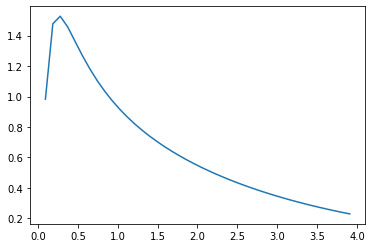

In [8]:
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

### or a training_set label

In [9]:
if False:
    emulator = NNEmulator(training_set='Cabayol23',nepochs=10)

#### If none or both are provided, the emulator fails. 

### Example 2: We can train a pre defined emulator... 

#### A. with a training_set label

In [10]:
# this would take a long time
if False:
    emulator = NNEmulator(training_set='Cabayol23', emulator_label='Cabayol23', nepochs=1)

#### B. with an archive

In [11]:
# passing a Pedersen21 archive and asking for Cabayol23 emulator settings
emulator = NNEmulator(archive=archive, emulator_label='Cabayol23', nepochs=10)

Use custom archive provided by the user
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<4.5. The parameters passed to the emulator will be overwritten to match these ones


### Example 3: Load a pre-trained emulator, providing the path of the saved network parameters

In [12]:
# this is now broken (we can not load pre-trained NN models)
if False:
    emulator = NNEmulator(training_set='Cabayol23',nepochs=1,
                          model_path='NNmodels/NNEmulator_LaCEHC.pt', train=False)

## GAUSSIAN PROCESS EMULATOR

## The Gaussian process emulator uses the following default parameters:

- paramList=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
- kmax_Mpc=10
- ndeg=4

### Example 1: Train custom emulator 

#### with a defined training_set

In [13]:
if False:
    emulator = GPEmulator(training_set='Pedersen21')

#### with a custom archive

In [14]:
emulator = GPEmulator(archive=archive)

Use custom archive provided by the user
Selected custom emulator
Training GP on 330 points


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.45 seconds


### Example 2: Pre-defined GP emulators:

In [15]:
if False:
    emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen21')

In [16]:
if False:
    emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen23')

In [17]:
if False:
    emulator = GPEmulator(training_set='Pedersen21')

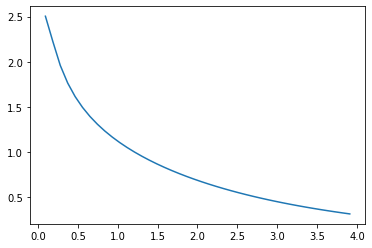

In [18]:
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

## LaCE-Nyx emulator (NN)

In [19]:
nyx_fname = '/Users/font/Projects/DESI/Nyx_sims/models.hdf5'
archive = nyx_archive.NyxArchive(nyx_fname)

In [20]:
emulator = NNEmulator(archive=archive, nepochs=1000,
                      emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc','gamma','lambda_P'])

Use custom archive provided by the user
Selected custom emulator


In [21]:
testing_data = archive.get_testing_data(sim_label='nyx_2')
print(len(testing_data))

15


In [22]:
kMpc = testing_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

In [23]:
for param in emulator.emu_params:
    print(param,testing_data[0][param])

Delta2_p 0.6124299899355301
n_p -2.342618217815043
mF 0.85196775
sigT_Mpc 0.16101706382280045
gamma 1.5756833
lambda_P 80.7531595531994


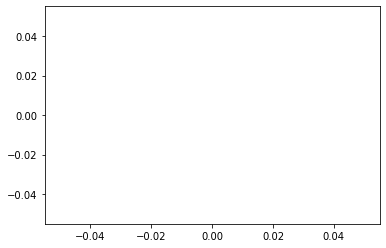

In [24]:
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

In [25]:
p1d

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)